# Pipelines & Feature Selection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import graphviz 

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, make_scorer, roc_curve, auc, f1_score, classification_report, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold
from sklearn.model_selection import ShuffleSplit, cross_val_predict

from sklearn.pipeline import Pipeline

from sklearn.feature_selection import chi2, mutual_info_classif, SelectKBest

from imblearn.over_sampling import SMOTE

import seaborn as sns

import statistics

%matplotlib inline


# 1. Rectifying Bias - cross validation

In [2]:
# Load  dataset
surv = pd.read_csv('survival.csv')
surv['Survived'] = 'GE5'
surv.loc[surv['Class']==2,'Survived']='L5'
surv.head()

,Age,Year,NNodes,Class,Survived
0,30,64,1,1,GE5
1,30,62,3,1,GE5
2,30,65,0,1,GE5
3,31,59,2,1,GE5
4,31,65,4,1,GE5


In [3]:
surv.shape

(306, 5)

In [4]:
surv['Survived'].value_counts() 

GE5    225
L5      81
Name: Survived, dtype: int64

In [5]:
surv_copy = surv.copy()
y = surv_copy.pop('Survived').values
y.shape
surv_copy.pop('Class')
X = surv_copy.values
X.shape, y.shape

((306, 3), (306,))

In [6]:
print("Majority class : %0.2f" % (Counter(y)['GE5']/len(y)))
print("Minority class : %0.2f" % (Counter(y)['L5']/len(y)))

Majority class : 0.74
Minority class : 0.26


### 1. From your first assignment submission, show the hold-out evaluation of the impact of your bias reduction strategy (just one strategy). This will serve as a base-line.

In [7]:
kNN = KNeighborsClassifier(n_neighbors=3)
dtree = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=6)
logR = LogisticRegression(solver='liblinear', random_state=42, C=1e5)
gbc = GradientBoostingClassifier(random_state=42, max_leaf_nodes=6)

models = [kNN, dtree, logR, gbc]
m_names = ['kNN', 'dTree', 'LogR', 'gbc']
classes=['GE5','L5']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Separate majority and minority classes
surv_majority = y_train[y_train == 'GE5']
surv_minority = y_train[y_train == 'L5']

sm = SMOTE(random_state=12)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [9]:
len(y_train), len(y_train_res)

(229, 340)

In [10]:
(Counter(y_train)['L5']), (Counter(y_train_res)['L5'])

(59, 170)

In [11]:
print("Original Training")
print("Majority class:",Counter(y_train)['GE5'])
print("Minority class:",Counter(y_train)['L5'])
print("Upsampled Training")
print("Majority class:",Counter(y_train_res)['GE5'])
print("Minority class:",Counter(y_train_res)['L5'])

Original Training
Majority class: 170
Minority class: 59
Upsampled Training
Majority class: 170
Minority class: 170


In [12]:
print("Minority in test set : %d" % Counter(y_test)['L5'])
res_d = {}
acc_res = {}

for i, m in enumerate(models):
    y_pred = m.fit(X_train_res, y_train_res).predict(X_test)
    pred_count =  Counter(y_pred)['L5']
    res_d[m] = pred_count
    acc = accuracy_score(y_test, y_pred)
    acc_res[m] = acc

    print("{:6} Pred. L5: {:d} Accuracy: {:.2f}".format(m_names[i], pred_count,acc))
     

Minority in test set : 22
kNN    Pred. L5: 32 Accuracy: 0.58
dTree  Pred. L5: 27 Accuracy: 0.65
LogR   Pred. L5: 29 Accuracy: 0.60
gbc    Pred. L5: 26 Accuracy: 0.61


In [13]:
def print_eveluations(m, cm):
    
    tp_sum = cm[0][0].sum()
    fp_sum = cm[1][0].sum()
    tn_sum = cm[1][1].sum()
    fn_sum = cm[0][1].sum()
    
    tp_rate = tp_sum /(tp_sum + fn_sum)
    fp_rate = fp_sum /(fp_sum + tn_sum)
    arr_rate = (tp_sum + tn_sum) / (tp_sum+fp_sum+tn_sum+fn_sum)
    recall_rate = tp_sum/(tp_sum+fn_sum)
    precision_rate = tp_sum/(tp_sum+fp_sum)
    f1 = 2 * precision_rate * recall_rate / (precision_rate + recall_rate)
  
    print("{:6} ACC: {:.2f}   TP: {:.2f}   FP: {:.2f}"
          .format(m, arr_rate, tp_rate, fp_rate, recall_rate, precision_rate, f1)) 

In [14]:
ori_d = {}
sm_d = {}

acc_d = {}
sm_acc_d = {}

for i, m in enumerate(models):
    
    y_pred = m.fit(X_train, y_train).predict(X_test)
    y_sm_pred = m.fit(X_train_res, y_train_res).predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    sm_cm = confusion_matrix(y_test, y_sm_pred, labels=classes)
    
    ori_d[m_names[i]] = Counter(y_pred)['L5']
    sm_d[m_names[i]] = Counter(y_sm_pred)['L5']
    
    acc_d[m_names[i]] = accuracy_score(y_test, y_pred)
    sm_acc_d[m_names[i]] = accuracy_score(y_test, y_sm_pred)
    
    print("=======")
    print_eveluations(m_names[i], cm) 
    print('resample..')
    print_eveluations(m_names[i], sm_cm) 

kNN    ACC: 0.70   TP: 0.87   FP: 0.73
resample..
kNN    ACC: 0.58   TP: 0.62   FP: 0.50
dTree  ACC: 0.69   TP: 0.82   FP: 0.64
resample..
dTree  ACC: 0.65   TP: 0.71   FP: 0.50
LogR   ACC: 0.71   TP: 0.91   FP: 0.77
resample..
LogR   ACC: 0.60   TP: 0.65   FP: 0.55
gbc    ACC: 0.68   TP: 0.85   FP: 0.77
resample..
gbc    ACC: 0.61   TP: 0.69   FP: 0.59


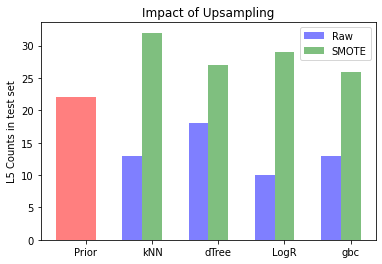

In [15]:
import matplotlib.pyplot as plt 
import numpy as np
%matplotlib inline 

fig, ax = plt.subplots()
width = 0.3

# Add the prior figures to the data for plotting
objects = ['Prior'] + list(ori_d.keys())
positive = [ Counter(y_test)['L5']] + list(ori_d.values())
res = [ Counter(y_test)['L5']] + list(sm_d.values())

y_pos = np.arange(len(objects))

p1 = ax.bar(y_pos-width, positive, width, align='center', 
            color=['red', 'blue', 'blue','blue','blue'],alpha=0.5)

p2 = ax.bar(y_pos, res, width, align='center', 
            color=['red', 'g','g','g','g'],alpha=0.5)


ax.legend((p1[1], p2[1]), ('Raw', 'SMOTE'))

plt.xticks(y_pos, objects)
plt.ylabel('L5 Counts in test set')
plt.title('Impact of Upsampling')
 
plt.show()

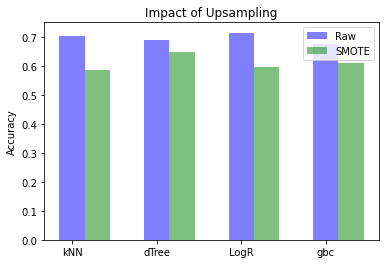

In [16]:
fig, ax = plt.subplots()

objects =  list(acc_d.keys())
before =   list(acc_d.values())
after =  list(sm_acc_d.values())
y_pos = np.arange(len(objects))
p1 = ax.bar(y_pos, before, width, align='center', 
            color=['blue', 'blue','blue','blue'],alpha=0.5)
p2 = ax.bar(y_pos+width, after, width, align='center', 
            color=['g','g','g','g'],alpha=0.5)
ax.legend((p1[1], p2[1]), ('Raw', 'SMOTE'))
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Impact of Upsampling')
plt.show()

### Evaluation using Holdout validation.

#### 50 times holdout evaluation

In [17]:
acc_hold = {'kNN':[], 'dTree':[], 'LogR':[], 'gbc':[]}
acc_hold_mean = {}
print("mean accuracy:")

for i, m in enumerate(models):
    for j in range(1, 50):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
        
        sm = SMOTE(random_state=12)
        X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
        
        y_pred = m.fit(X_train_res, y_train_res).predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        
        acc_hold[m_names[i]].append(acc)
    
    acc_hold_mean[m_names[i]] = np.mean(acc_hold[m_names[i]])
    print("{:6} {:.2f}".format(m_names[i], np.mean(acc_hold[m_names[i]])))

mean accuracy:
kNN    0.63
dTree  0.65
LogR   0.70
gbc    0.63


Text(0.5, 1.0, 'Accuracy with 4 classifier (holdout)')

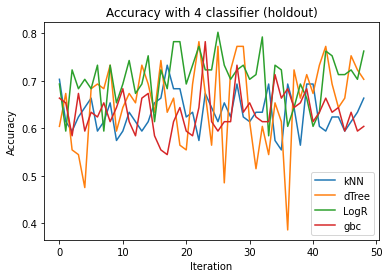

In [18]:
df = pd.DataFrame()
for m_name in m_names:
    df[m_name] = acc_hold[m_name]
%matplotlib inline
ax = df.plot()
ax.set_xlabel("Iteration")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy with 4 classifier (holdout)")

In [19]:
for m_n in m_names:
    print("{:6} acc range: {:.2f} - {:.2f}".format(m_n, df[m_n].min(), df[m_n].max() ))

kNN    acc range: 0.55 - 0.73
dTree  acc range: 0.39 - 0.78
LogR   acc range: 0.58 - 0.80
gbc    acc range: 0.54 - 0.78


- The line chart shows that hold out evaluation is not stable.
- Range of the accuracy from 50 times holdout evaluation are huge. For example, the model LogR has the biggest difference of range between minimum and maximun accuracy which is 0.23.

### Use a Pipeline to repeat this evaluation using cross validation.

In [20]:
from imblearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [21]:
kNN = KNeighborsClassifier()
dtree = DecisionTreeClassifier()
logR = LogisticRegression()
gbc = GradientBoostingClassifier()

models = [kNN, dtree, logR, gbc]

#### cross validation result - once time

In [22]:
acc_once = []
for i, m in enumerate(models):
    
    smt = SMOTE(random_state=42)
    pipeline = Pipeline([
        ('smt', smt),
        ('classifier', m)])
    
    y_pred = cross_val_predict(pipeline, X, y, cv=30)
    acc = accuracy_score(y, y_pred)
    acc_once.append(acc)
    cm = confusion_matrix(y, y_pred, labels=classes)
    print_eveluations(m_names[i], cm) 

kNN    ACC: 0.58   TP: 0.63   FP: 0.54
dTree  ACC: 0.59   TP: 0.68   FP: 0.64
LogR   ACC: 0.72   TP: 0.79   FP: 0.47
gbc    ACC: 0.54   TP: 0.61   FP: 0.65


#### Cross validation result - run 50 times

In [23]:
acc_pip = {'kNN':[], 'dTree':[], 'LogR':[], 'gbc':[]}
acc_pip_mean = {}
print("mean accuracy:")

for i, m in enumerate(models):
    for j in range(1, 50):
        smt = SMOTE(random_state=42)
        pipeline = Pipeline([
            ('smt', smt),
            ('classifier', m)])

        y_pred = cross_val_predict(pipeline, X, y, cv=20)
        acc = accuracy_score(y, y_pred)
        acc_pip[m_names[i]].append(acc)
    
    acc_pip_mean[m_names[i]] = np.mean(acc_pip[m_names[i]])
    print("{:6} {:.2f}".format(m_names[i], np.mean(acc_pip[m_names[i]])))

mean accuracy:
kNN    0.61
dTree  0.62
LogR   0.73
gbc    0.62


The line graph shows the result of the cross validation when run over a period of 50 times

Text(0.5, 1.0, 'Accuracy with 4 classifier (pipeline)')

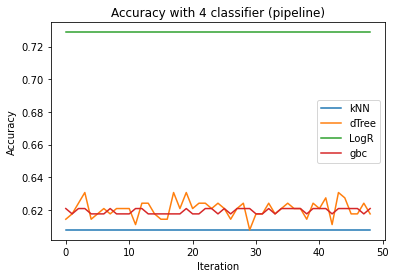

In [24]:
df = pd.DataFrame()
for m_name in m_names:
    df[m_name] = acc_pip[m_name]
%matplotlib inline
ax = df.plot()
ax.set_xlabel("Iteration")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy with 4 classifier (pipeline)")

In [25]:
for m_n in m_names:
    print("{:6} acc range: {:.2f} - {:.2f}".format(m_n, df[m_n].min(), df[m_n].max() ))

kNN    acc range: 0.61 - 0.61
dTree  acc range: 0.61 - 0.63
LogR   acc range: 0.73 - 0.73
gbc    acc range: 0.62 - 0.62


- The line chart shows that cross validation is more stable then holdout.
- Range of the accuracy from 50 times cross validation are small. For example, the model dTree has the biggest difference of range between minimum and maximun accuracy of these 4 models, which is still only 0.02.
- Accuracy range of holdout is 10 times larger than cross validation, which indicates cross validation is more stable than holdout evaluation.

#### Bar chart about accuracy score between different validation strategies

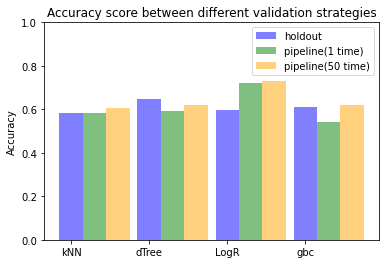

In [26]:
fig, ax = plt.subplots()

objects =  list(sm_acc_d.keys())
sm =  list(after)
pip_mean =  list(acc_pip_mean.values())

y_pos = np.arange(len(objects))
p1 = ax.bar(y_pos, sm, width, align='center', 
            color=['blue', 'blue','blue','blue'],alpha=0.5)
p2 = ax.bar(y_pos+width, acc_once, width, align='center', 
            color=['g','g','g','g'],alpha=0.5)
p3 = ax.bar(y_pos+width+width, pip_mean, width, align='center', 
            color=['orange','orange','orange','orange'],alpha=0.5)

ax.set_ylim([0,1])

ax.legend((p1[1], p2[1], p3[1]), ('holdout', 'pipeline(1 time)', 'pipeline(50 time)'))
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Accuracy score between different validation strategies')
plt.show()

### pipeline  + Grid Search 

In [27]:
acc_pip_gs = {'kNN':[], 'dTree':[], 'LogR':[], 'gbc':[]}
acc_pip_gs_mean = {}
for i, m in enumerate(models):
    smt = SMOTE(random_state=42)
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('smt', smt),
        ('classifier', m)])

    # hyperparameters
    parms = {'kNN': 
             {'classifier__n_neighbors':[1,3,5,10],
              'classifier__metric':['manhattan','euclidean']},
             'dTree': 
             {'classifier__criterion':['gini', 'entropy'],
              'classifier__max_leaf_nodes': [2,4,6,8,10]},
             'LogR':
             {'classifier__fit_intercept':[True, False],
              'classifier__solver': ['lbfgs', 'liblinear']},
             'gbc': 
             {'classifier__max_leaf_nodes':[2,4,6,8,10]}}


    gs = GridSearchCV(pipeline, parms[m_names[i]], cv=10)
    gs.fit(X, y)

    y_pred = cross_val_predict(gs, X, y, cv=10)
    acc = accuracy_score(y, y_pred)
    acc_pip_gs[m_names[i]].append(acc)

    acc_pip_gs_mean[m_names[i]] = np.mean(acc_pip_gs[m_names[i]])
    print(gs.best_estimator_.get_params()['classifier'])
    print("{:6} {:.2f}".format(m_names[i], np.mean(acc_pip_gs[m_names[i]])))

KNeighborsClassifier(metric='euclidean', n_neighbors=1)
kNN    0.67
DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=6)
dTree  0.70
LogisticRegression()
LogR   0.72
GradientBoostingClassifier(max_leaf_nodes=2)
gbc    0.64


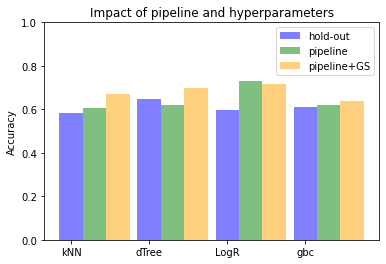

In [28]:
fig, ax = plt.subplots()

objects =  list(sm_acc_d.keys())
sm =  list(sm_acc_d.values())
pip_mean =  list(acc_pip_mean.values())
pip_gs_mean =  list(acc_pip_gs_mean.values())

y_pos = np.arange(len(objects))
p1 = ax.bar(y_pos, sm, width, align='center', 
            color=['blue', 'blue','blue','blue'],alpha=0.5)
p2 = ax.bar(y_pos+width, pip_mean, width, align='center', 
            color=['g','g','g','g'],alpha=0.5)
p3 = ax.bar(y_pos+width+width, pip_gs_mean, width, align='center', 
            color=['orange','orange','orange','orange'],alpha=0.5)

ax.set_ylim([0,1])

ax.legend((p1[1], p2[1], p3[1]), ('hold-out', 'pipeline', 'pipeline+GS'))
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Impact of pipeline and hyperparameters')
plt.show()

# 2. Feature Selection


### 1. Use Gradient Boosting as your classifier

In [29]:
heart_train = pd.read_csv('heart-train.csv')
heart_train['DEATH_EVENT'].value_counts() 

0    135
1     64
Name: DEATH_EVENT, dtype: int64

In [30]:
features = heart_train.columns
features

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

In [31]:
heart_train.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,60.0,0,253,0,35,0,279000.00,1.70,140,1,0,250,0
1,40.0,1,129,0,35,0,255000.00,0.90,137,1,0,209,0
2,86.0,0,582,0,38,0,263358.03,1.83,134,0,0,95,1
3,45.0,0,582,0,35,0,385000.00,1.00,145,1,0,61,1
4,72.0,0,127,1,50,1,218000.00,1.00,134,1,0,33,0


In [32]:
y_train = heart_train.pop('DEATH_EVENT').values
X_train = heart_train.values
X_train.shape, y_train.shape

((199, 12), (199,))

In [33]:
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [34]:
heart_test = pd.read_csv('heart-test.csv')
y_test = heart_test.pop('DEATH_EVENT').values
X_test = heart_test.values
X_test.shape, y_test.shape

((100, 12), (100,))

In [35]:
gbc = GradientBoostingClassifier(random_state=42, max_leaf_nodes=6)

In [36]:
# heart_train.boxplot(['serum_creatinine'])

This is imbalanced dataset

### Baseline 
#### Result of training data (cross validation) & Result of testing data (hold-out)

In [37]:
train_xv = []
test_hold = []

gbc = gbc.fit(X_train, y_train)
    
for i in range(100):
    
    # testing with training data
    cv = ShuffleSplit(n_splits=10, test_size=0.5, random_state=i)
    scores = cross_val_score(gbc, X_train, y_train, cv=cv)
    train_xv.append(scores.mean())
    
    y_pred = gbc.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    test_hold.append(acc)
    
mean_xv = sum(train_xv) / len(train_xv)
mean_test_hold = sum(test_hold) / len(test_hold)
print("Accuracy with all features:")
print("train data acc (xval)  : ", mean_xv)
print("test data acc (holdout): ", mean_test_hold)

Accuracy with all features:
train data acc (xval)  :  0.8292814814814815
test data acc (holdout):  0.8499999999999993


### Feature Scoring - Information Gain

In [38]:
i_scores = mutual_info_classif(X_train, y_train)
i_scores

array([0.13057692, 0.08245361, 0.05759941, 0.07227355, 0.20909019,
       0.06464933, 0.0307836 , 0.16260727, 0.11807368, 0.07448335,
       0.05478763, 0.27556209])

In [39]:
mi = dict()
for i,j in zip(heart_train.columns, i_scores):
    mi[i]=j

In [40]:
df = pd.DataFrame.from_dict(mi, orient='index', columns=['I-Gain'])
df.sort_values(by=['I-Gain'],ascending=False,inplace=True)
df

,I-Gain
time,0.275562
ejection_fraction,0.209090
serum_creatinine,0.162607
age,0.130577
serum_sodium,0.118074
anaemia,0.082454
sex,0.074483
diabetes,0.072274
high_blood_pressure,0.064649
creatinine_phosphokinase,0.057599


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


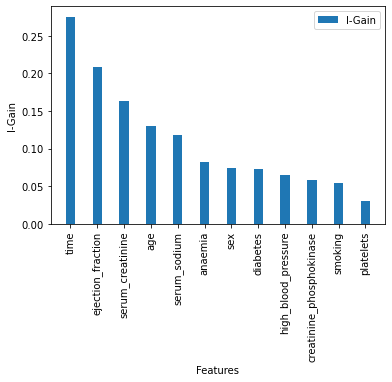

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

n = len(df.index)
rr = range(1,n)
fig, ax = plt.subplots()
ax.bar(df.index, df["I-Gain"], label='I-Gain',width=.35)
ax.set_xticklabels(list(df.index), rotation = 90)
ax.set_xlabel('Features')
ax.set_ylabel('I-Gain')
ax.legend()

plt.show()

Everytime I run the function mutual_info_classif, will ger different IG score. 

### Run multiple time to see the iscore of all features

In [42]:
t = 20
ig_d = {}
for k in range(0, t):
    i_scores = mutual_info_classif(X_train, y_train)
    
    for i,j in zip(heart_train.columns, i_scores):
        if i in ig_d:
            ig_d[i].append(j)
        else:
            ig_d[i]=[j]


In [43]:
df_ig = pd.DataFrame.from_dict(ig_d, orient='index')
df_ig['ig-mean'] = df_ig.mean(axis=1)
df_ig.sort_values(by=['ig-mean'],ascending=False,inplace=True)
# df_ig

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


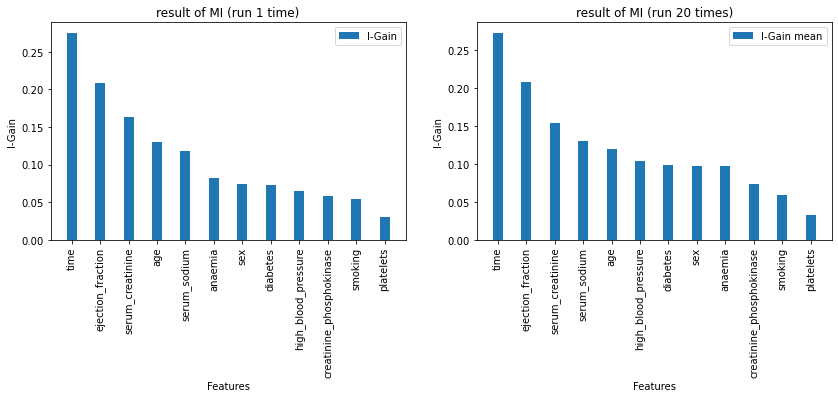

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
axes[0].bar(df.index, df["I-Gain"], label='I-Gain',width=.35)
axes[0].set_xticklabels(list(df.index), rotation = 90)
axes[0].set_title('result of MI (run 1 time)')
axes[0].set_xlabel('Features')
axes[0].set_ylabel('I-Gain')
axes[0].legend()


axes[1].bar(df.index, df_ig["ig-mean"], label='I-Gain mean',width=.35)
axes[1].set_xticklabels(list(df_ig.index), rotation = 90)
axes[1].set_title('result of MI (run 20 times)')
axes[1].set_xlabel('Features')
axes[1].set_ylabel('I-Gain')
axes[1].legend()

plt.show()

After running multitple times, the plots show that the sequence of IG score of the top 2 features are still the same.

#### Get accuracy of different subset of features (Run once time)

In [45]:
cols_index = []
acc_scores = []
for kk in range(1, X_train.shape[1]+1):
    
    FS_trans = SelectKBest(mutual_info_classif, 
                           k=kk).fit(X_train, y_train)
    
    #get selected k index
    cols = FS_trans.get_support(indices=True)
    cols_index.append(cols)
    
    # transform data
    X_tR_new = FS_trans.transform(X_train)
    
    # get xval accuracy score according to different value of k
    scores = cross_val_score(gbc, X_tR_new, y_train, cv=5, scoring='accuracy')
    acc_scores.append(scores.mean())

df['Cols'] = cols_index
df['Accuracy'] = acc_scores
df.head(12)

,I-Gain,Cols,Accuracy
time,0.275562,[11],0.744444
ejection_fraction,0.209090,"[4, 11]",0.803704
serum_creatinine,0.162607,"[4, 7, 11]",0.855556
age,0.130577,"[1, 4, 7, 11]",0.844444
serum_sodium,0.118074,"[0, 3, 4, 7, 11]",0.837037
anaemia,0.082454,"[0, 4, 5, 7, 8, 11]",0.840741
sex,0.074483,"[0, 3, 4, 5, 7, 8, 11]",0.840741
diabetes,0.072274,"[0, 1, 2, 4, 7, 8, 10, 11]",0.870370
high_blood_pressure,0.064649,"[0, 1, 3, 4, 5, 7, 8, 9, 11]",0.859259
creatinine_phosphokinase,0.057599,"[0, 1, 3, 4, 5, 7, 8, 9, 10, 11]",0.840741


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


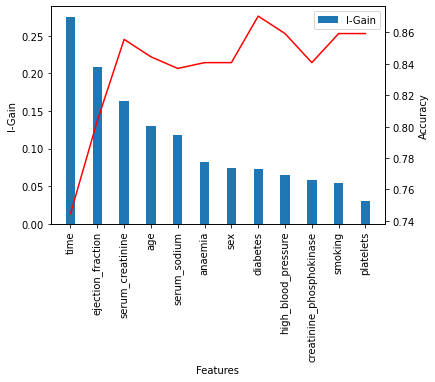

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.bar(df.index, df["I-Gain"], label='I-Gain',width=.35)
ax2.plot(df.index, df["Accuracy"], color='red', label='Accuracy')
ax.set_xticklabels(list(df.index), rotation = 90)
ax.set_xlabel('Features')
ax.set_ylabel('I-Gain')
ax2.set_ylabel('Accuracy')
ax.legend()

plt.show()

In this experience, selecting 11 and 12 features seems like have highest accuracy which is 0.86. Next, I would like to run multiple time SelectKBest, and campare the result with the previous experience.

#### Get accuracy of different subset of features (Run multiple times)

In [47]:
t = 20
df_acc = pd.DataFrame()
for k in range(0, t):  
    
    acc_scores = []
    for kk in range(1, X_train.shape[1]+1):
        
        FS_trans = SelectKBest(mutual_info_classif, 
                           k=kk).fit(X_train, y_train)
        X_tR_new = FS_trans.transform(X_train)
    
        scores = cross_val_score(gbc, X_tR_new, y_train, cv=5, scoring='accuracy')
        acc_scores.append(scores.mean())
    df_acc['Accuracy_'+str(k)] = acc_scores

In [48]:
df_acc['acc-mean'] = df_acc.mean(axis=1)
df_acc = df_acc.sort_index()
# df_acc

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


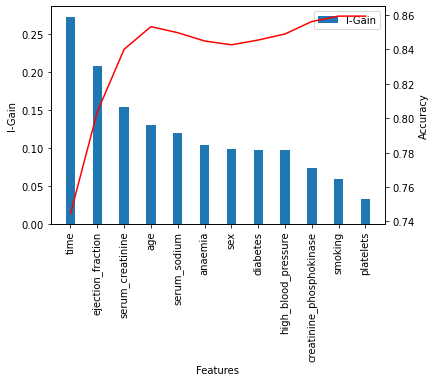

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

n = len(df.index)
rr = range(1,n)
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.bar(df.index, df_ig["ig-mean"], label='I-Gain',width=.35)
ax2.plot(df.index, df_acc['acc-mean'], color='red', label='Accuracy')
ax.set_xticklabels(list(df.index), rotation = 90)
ax.set_xlabel('Features')
ax.set_ylabel('I-Gain')
ax2.set_ylabel('Accuracy')
ax.legend()

plt.show()

In [50]:
for i in range(0, len(df_acc['acc-mean'])):
#     print('{:}features acc:, df_acc['acc-mean'][i]'')
    print("{:2} features  acc {:.2f}".format(i+1, df_acc['acc-mean'][i]))

 1 features  acc 0.74
 2 features  acc 0.80
 3 features  acc 0.84
 4 features  acc 0.85
 5 features  acc 0.85
 6 features  acc 0.84
 7 features  acc 0.84
 8 features  acc 0.85
 9 features  acc 0.85
10 features  acc 0.86
11 features  acc 0.86
12 features  acc 0.86


The plot shows that there have the highest k is 4, 10, 11 and 12, which the accuracy are all 0.86. Next I would like to eveluate it with test set. 

In [51]:
selected_k = [4, 10, 11]

In [52]:
def print_features(i, features):
    fs = ""
    for j in i: 
        fs += features[j]
        fs += ", "
    print(fs)
    

In [53]:
test_acc = []
for i in selected_k:
    print("Selected {:2} features :".format(i))
    print_features(cols_index[i-1], features)
    
    # only selected k features
    train_data = X_train[:, cols_index[i-1]]
    test_data = X_test[:, cols_index[i-1]]
    
    # train model
    gbc = gbc.fit(train_data, y_train)
    
    # test model
    y_dash = gbc.predict(test_data)
    acc = accuracy_score(y_test, y_dash)
    test_acc.append(acc)
    print("acc:", acc)
    print()

Selected  4 features :
anaemia, ejection_fraction, serum_creatinine, time, 
acc: 0.86

Selected 10 features :
age, anaemia, diabetes, ejection_fraction, high_blood_pressure, serum_creatinine, serum_sodium, sex, smoking, time, 
acc: 0.82

Selected 11 features :
age, anaemia, creatinine_phosphokinase, diabetes, ejection_fraction, high_blood_pressure, serum_creatinine, serum_sodium, sex, smoking, time, 
acc: 0.85



In [54]:
test_acc

[0.86, 0.82, 0.85]

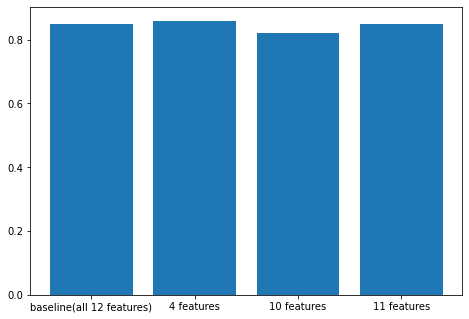

In [55]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['baseline(all 12 features)', '4 features', '10 features', '11 features']
y = [mean_test_hold, 
            test_acc[0],
            test_acc[1],
            test_acc[2]]
ax.bar(x, y)
plt.show()

Issues about filters: 
 - No Model Bias
 - No Feature Dependencies

### Wrapper

In [56]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [57]:
gbc = GradientBoostingClassifier(random_state=42, max_leaf_nodes=6)
feature_names = heart_train.columns

sfs_backward = SFS(gbc, 
                  k_features=1, 
                  forward=False, 
                  floating=False, 
#                   verbose=1,
                  scoring='accuracy',
                  cv=5)

sfs_backward = sfs_backward.fit(X_train, y_train,  
                              custom_feature_names=feature_names)

In [58]:
sfs_df = pd.DataFrame.from_dict(sfs_backward.get_metric_dict())
sfs_df.T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
12,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)","[0.8148148148148148, 0.8518518518518519, 0.870...",0.859259,"(age, anaemia, creatinine_phosphokinase, diabe...",0.0490107,0.038132,0.019066
11,"(0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11)","[0.8333333333333334, 0.8888888888888888, 0.870...",0.874074,"(age, anaemia, creatinine_phosphokinase, eject...",0.0530089,0.0412427,0.0206213
10,"(0, 1, 2, 4, 6, 7, 8, 9, 10, 11)","[0.8333333333333334, 0.8888888888888888, 0.888...",0.877778,"(age, anaemia, creatinine_phosphokinase, eject...",0.0534346,0.041574,0.020787
9,"(1, 2, 4, 6, 7, 8, 9, 10, 11)","[0.8333333333333334, 0.8518518518518519, 0.870...",0.877778,"(anaemia, creatinine_phosphokinase, ejection_f...",0.0575194,0.044752,0.022376
8,"(2, 4, 6, 7, 8, 9, 10, 11)","[0.8333333333333334, 0.8333333333333334, 0.907...",0.877778,"(creatinine_phosphokinase, ejection_fraction, ...",0.0555146,0.0431922,0.0215961
7,"(2, 4, 6, 7, 8, 9, 11)","[0.8333333333333334, 0.8148148148148148, 0.870...",0.866667,"(creatinine_phosphokinase, ejection_fraction, ...",0.057124,0.0444444,0.0222222
6,"(2, 4, 6, 7, 9, 11)","[0.7962962962962963, 0.9074074074074074, 0.851...",0.874074,"(creatinine_phosphokinase, ejection_fraction, ...",0.0645723,0.0502395,0.0251197
5,"(2, 4, 7, 9, 11)","[0.8148148148148148, 0.8333333333333334, 0.888...",0.87037,"(creatinine_phosphokinase, ejection_fraction, ...",0.058302,0.0453609,0.0226805
4,"(4, 7, 9, 11)","[0.8148148148148148, 0.7962962962962963, 0.870...",0.851852,"(ejection_fraction, serum_creatinine, sex, time)",0.0521469,0.040572,0.020286
3,"(4, 7, 11)","[0.8333333333333334, 0.7962962962962963, 0.851...",0.851852,"(ejection_fraction, serum_creatinine, time)",0.0476034,0.037037,0.0185185


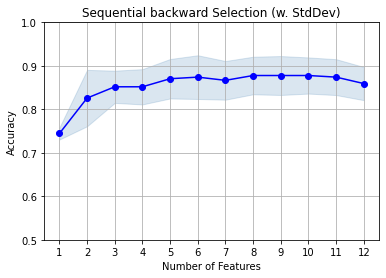

In [59]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt


fig2 = plot_sfs(sfs_backward.get_metric_dict(), 
                ylabel='Accuracy',
                kind='std_dev')


plt.ylim([0.5, 1])
plt.title('Sequential backward Selection (w. StdDev)')
plt.grid()
plt.show()

When the cv is set to 5:
- The plot shows that k with 5, 6, 8, 9, 10, 11 have highest acccuracy score, which are all 0.87. 

In [60]:
gbc = GradientBoostingClassifier(random_state=42, max_leaf_nodes=6)
feature_names = heart_train.columns

sfs_backward = SFS(gbc, 
                  k_features=1, 
                  forward=False, 
                  floating=False, 
#                   verbose=1,
                  scoring='accuracy',
                  cv=10)

sfs_backward = sfs_backward.fit(X_train, y_train,  
                              custom_feature_names=feature_names)

In [61]:
# sfs_backward.subsets_

In [62]:
sfs_df = pd.DataFrame.from_dict(sfs_backward.get_metric_dict())
sfs_df.T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
12,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)","[0.7407407407407407, 0.8518518518518519, 0.888...",0.862963,"(age, anaemia, creatinine_phosphokinase, diabe...",0.0492844,0.0663573,0.0221191
11,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)","[0.7037037037037037, 0.8148148148148148, 0.888...",0.859259,"(anaemia, creatinine_phosphokinase, diabetes, ...",0.0473264,0.0637209,0.0212403
10,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 11)","[0.7037037037037037, 0.8518518518518519, 0.888...",0.866667,"(anaemia, creatinine_phosphokinase, diabetes, ...",0.0495142,0.0666667,0.0222222
9,"(1, 2, 3, 4, 6, 7, 8, 9, 11)","[0.7407407407407407, 0.8518518518518519, 0.851...",0.87037,"(anaemia, creatinine_phosphokinase, diabetes, ...",0.0447796,0.0602919,0.0200973
8,"(2, 3, 4, 6, 7, 8, 9, 11)","[0.7407407407407407, 0.8518518518518519, 0.851...",0.87037,"(creatinine_phosphokinase, diabetes, ejection_...",0.0447796,0.0602919,0.0200973
7,"(2, 4, 6, 7, 8, 9, 11)","[0.7407407407407407, 0.8888888888888888, 0.851...",0.87037,"(creatinine_phosphokinase, ejection_fraction, ...",0.0430567,0.0579721,0.019324
6,"(2, 4, 6, 7, 9, 11)","[0.7037037037037037, 0.8888888888888888, 0.925...",0.866667,"(creatinine_phosphokinase, ejection_fraction, ...",0.0524817,0.0706622,0.0235541
5,"(4, 6, 7, 9, 11)","[0.7037037037037037, 0.8148148148148148, 0.851...",0.859259,"(ejection_fraction, platelets, serum_creatinin...",0.0504228,0.06789,0.02263
4,"(6, 7, 9, 11)","[0.7777777777777778, 0.8518518518518519, 0.814...",0.862963,"(platelets, serum_creatinine, sex, time)",0.0427037,0.0574969,0.0191656
3,"(6, 7, 11)","[0.7777777777777778, 0.8518518518518519, 0.814...",0.855556,"(platelets, serum_creatinine, time)",0.0357603,0.0481481,0.0160494


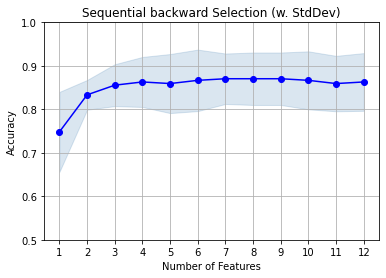

In [63]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt


fig2 = plot_sfs(sfs_backward.get_metric_dict(), 
                ylabel='Accuracy',
                kind='std_dev')


plt.ylim([0.5, 1])
plt.title('Sequential backward Selection (w. StdDev)')
plt.grid()
plt.show()


When cv is set to 10:
- The plot shows that k with 7, 8, 9 have highest acccuracy score, which are all 0.87. 

Since the common vlaue of selected k is 8 and 9, and they both have same accuracy which is 0.87, therefore value 8 is considering as the best value. However, Both value of 5, 6, 7, 8, 9, 10 and 11 will be eveluated to compare the result.

### Test with test data

In [64]:
sfs_df[1].avg_score

0.7481481481481482

In [65]:
selected_k = [5, 6, 7, 8, 9, 10 ,11]
train_acc =[]
test_acc = []

for i in selected_k:
    print("Selected {:2} features :".format(i))
    print_features(list(sfs_df[i]['feature_idx']), features)
    train_acc.append(sfs_df[i].avg_score)
    
    # only selected k features
    train_data = X_train[:, cols_index[i-1]]
    test_data = X_test[:, cols_index[i-1]]
    
    # train model
    gbc = gbc.fit(train_data, y_train)
    
    # test model
    y_dash = gbc.predict(test_data)
    acc = accuracy_score(y_test, y_dash)
    test_acc.append(acc)
    print("acc:", acc)
    print()

Selected  5 features :
ejection_fraction, platelets, serum_creatinine, sex, time, 
acc: 0.84

Selected  6 features :
creatinine_phosphokinase, ejection_fraction, platelets, serum_creatinine, sex, time, 
acc: 0.84

Selected  7 features :
creatinine_phosphokinase, ejection_fraction, platelets, serum_creatinine, serum_sodium, sex, time, 
acc: 0.83

Selected  8 features :
creatinine_phosphokinase, diabetes, ejection_fraction, platelets, serum_creatinine, serum_sodium, sex, time, 
acc: 0.85

Selected  9 features :
anaemia, creatinine_phosphokinase, diabetes, ejection_fraction, platelets, serum_creatinine, serum_sodium, sex, time, 
acc: 0.81

Selected 10 features :
anaemia, creatinine_phosphokinase, diabetes, ejection_fraction, high_blood_pressure, platelets, serum_creatinine, serum_sodium, sex, time, 
acc: 0.82

Selected 11 features :
anaemia, creatinine_phosphokinase, diabetes, ejection_fraction, high_blood_pressure, platelets, serum_creatinine, serum_sodium, sex, smoking, time, 
acc: 0.85

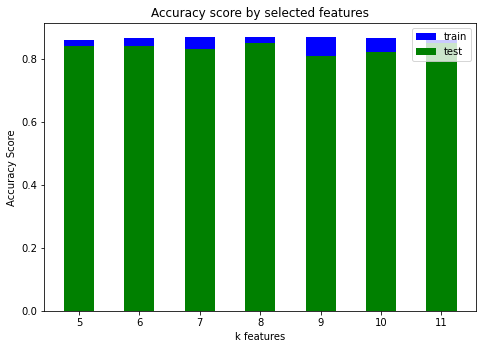

In [66]:
data = [train_acc, test_acc]
X = np.arange(len(selected_k))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X, data[0], color = 'b', width = 0.5)
ax.bar(X, data[1], color = 'g', width = 0.5)
ax.set_title('Accuracy score by selected features')
ax.set_ylabel('Accuracy Score')
ax.set_xlabel('k features')
ax.legend(labels=['train', 'test'])
plt.xticks(np.arange(len(selected_k)), selected_k)
plt.show()


In [67]:
sfs_acc_df = pd.DataFrame.from_dict({'train_acc': train_acc, 'test_acc': test_acc, 'k': range(5, 12)})
sfs_acc_df["diff"] = sfs_acc_df["train_acc"] - sfs_acc_df["test_acc"]
sfs_acc_df.sort_values(by=['diff'])

,train_acc,test_acc,k,diff
6,0.859259,0.85,11,0.009259
0,0.859259,0.84,5,0.019259
3,0.870370,0.85,8,0.020370
1,0.866667,0.84,6,0.026667
2,0.870370,0.83,7,0.040370
5,0.866667,0.82,10,0.046667
4,0.870370,0.81,9,0.060370


The plot shows the sccuracy score comparison between testing set and training set. 
- When the value of k is 7, has highest accuracy and less difference between training and testing accuracy score, which means it has low bias and low variance.
- When the value of k are 9, 10 and 11, the model is overfitting, because the model is too complicated.

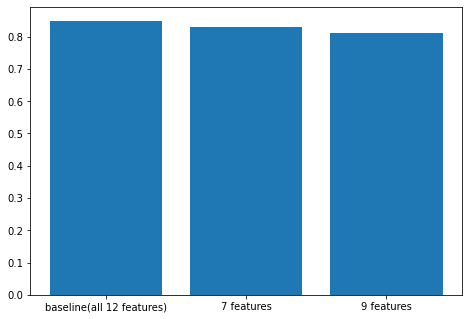

In [68]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['baseline(all 12 features)', '7 features', '9 features', ]
y = [mean_test_hold, 
     test_acc[2],
     test_acc[4],]
ax.bar(x, y)
plt.show()